# Customer Churn Modeling using Random Forest and Neural Net

This project is predictive modeling of banking customers and thier churn rate. The dataset was downloaded as part of an online course, though the name of the course itself was not recorded, thus this dataset is a bit of a mystery. It is available at the official website of the California State University East Bay Data Science Club.

The tools we will use:

In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

In [3]:
from sklearn.model_selection import train_test_split 
from keras.models import Sequential 
from keras.layers import InputLayer 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.constraints import maxnorm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
data = pd.read_csv("Churn-Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### A bit of feature engineering:
This custom function segments the features into three parts according to their interquartile range.

In [5]:
def featureSeg(col, lower, upper):
    new_list = []
    for i in col:
        if i < lower:
            new_list.append("lower")
        elif i > lower and i < upper:
            new_list.append("moderate")
        else:
            new_list.append("high")
    return new_list

Here we convert the numerical data to boolean values.

In [6]:
data.Exited.replace([0,1], ["No", "Yes"], inplace=True)
data.IsActiveMember.replace([0,1], ["No", "Yes"], inplace=True)
data.HasCrCard.replace([0,1], ["No", "Yes"], inplace=True)

For the features below we run the describe() function to find the values to set our bounds for the feature segmenting function we wrote earlier.

In [7]:
data['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

In [8]:
data['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [9]:
data['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [10]:
data['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

Now we create new features from the output of our function.

In [11]:
data['IncomeClass'] = featureSeg(data['EstimatedSalary'], 51000, 149000)

In [12]:
data['BalanceClass'] = featureSeg(data['Balance'], 97000, 125000)

In [13]:
data['CreditClass'] = featureSeg(data['CreditScore'], 584, 718)

In [14]:
data['Age'] = featureSeg(data['Age'], 32, 44)

In [15]:
data['Tenure'] = featureSeg(data['Tenure'], 4, 7)

In [16]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IncomeClass,BalanceClass,CreditClass
0,1,15634602,Hargrave,619,France,Female,moderate,lower,0.00,1,Yes,Yes,101348.88,Yes,moderate,lower,moderate
1,2,15647311,Hill,608,Spain,Female,moderate,lower,83807.86,1,No,Yes,112542.58,No,moderate,lower,moderate
2,3,15619304,Onio,502,France,Female,moderate,high,159660.80,3,Yes,No,113931.57,Yes,moderate,high,lower
3,4,15701354,Boni,699,France,Female,moderate,lower,0.00,2,No,No,93826.63,No,moderate,lower,moderate
4,5,15737888,Mitchell,850,Spain,Female,moderate,lower,125510.82,1,Yes,Yes,79084.10,No,moderate,high,high


Here we subset the data with the new features we have created along with a few others that will be useful in our analysis. 

In [17]:
sub_data = data[['Geography', 'Gender', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'IncomeClass', 'BalanceClass', 'CreditClass', 'Tenure', 'Exited']]

In [18]:
sub_data.head()

,Geography,Gender,Age,NumOfProducts,HasCrCard,IsActiveMember,IncomeClass,BalanceClass,CreditClass,Tenure,Exited
0,France,Female,moderate,1,Yes,Yes,moderate,lower,moderate,lower,Yes
1,Spain,Female,moderate,1,No,Yes,moderate,lower,moderate,lower,No
2,France,Female,moderate,3,Yes,No,moderate,high,lower,high,Yes
3,France,Female,moderate,2,No,No,moderate,lower,moderate,lower,No
4,Spain,Female,moderate,1,Yes,Yes,moderate,high,high,lower,No


The get_dummies() function creates dummy variables with each unique value in the features we run the function on, this is why we had to massage the data with the feature engineering above.

In [19]:
sub_data = pd.get_dummies(sub_data)

In [20]:
sub_data.head()
sub_data.drop('Exited_No', axis=1)

,NumOfProducts,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age_high,Age_lower,Age_moderate,HasCrCard_No,...,BalanceClass_high,BalanceClass_lower,BalanceClass_moderate,CreditClass_high,CreditClass_lower,CreditClass_moderate,Tenure_high,Tenure_lower,Tenure_moderate,Exited_Yes
0,1,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
1,1,0,0,1,1,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
2,3,1,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
3,2,1,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
4,1,0,0,1,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
9996,1,1,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,0
9997,1,1,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,1,0,0,1
9998,2,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1


We separate the data into a matrix without the labels and a vector with only the labels that indicates the churning.

In [21]:
X = sub_data.drop(['Exited_Yes', 'Exited_No'], axis=1)
y = sub_data.Exited_Yes

In [22]:
X

,NumOfProducts,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age_high,Age_lower,Age_moderate,HasCrCard_No,...,IncomeClass_moderate,BalanceClass_high,BalanceClass_lower,BalanceClass_moderate,CreditClass_high,CreditClass_lower,CreditClass_moderate,Tenure_high,Tenure_lower,Tenure_moderate
0,1,1,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,1,0,1,0
1,1,0,0,1,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,1,0
2,3,1,0,0,1,0,0,0,1,0,...,1,1,0,0,0,1,0,1,0,0
3,2,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,1,0
4,1,0,0,1,1,0,0,0,1,0,...,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1,0,0,0,1,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
9996,1,1,0,0,0,1,0,0,1,0,...,1,0,1,0,0,1,0,1,0,0
9997,1,1,0,0,1,0,0,0,1,1,...,0,0,1,0,0,0,1,1,0,0
9998,2,0,1,0,0,1,0,0,1,0,...,1,0,1,0,1,0,0,0,1,0


Here we split the data into 80/20 training and testing subsets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Random Forest


Now we can begin the analysis using the RandomForestClassifier algorithm. We will build 100 trees with a maximum depth of 20 nodes, and a random_state of 42.

In [24]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 42)

rf.fit(X_train, y_train)
score = rf.score(X_train, y_train)
score2 = rf.score(X_test, y_test)
print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.926
Test set accuracy:  0.827


82.5% accuracy on the test set, not bad!

Now we can predict and compare our precision vs our accuracy.

In [25]:
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)

In [26]:
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1482  125]
 [ 222  171]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1607
           1       0.58      0.44      0.50       393

    accuracy                           0.83      2000
   macro avg       0.72      0.68      0.70      2000
weighted avg       0.81      0.83      0.82      2000

0.8265


We can see which features are most influential in our predictions here.

In [27]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,NumOfProducts,0.212950
6,Age_high,0.080279
22,Tenure_high,0.039660
23,Tenure_lower,0.039590
21,CreditClass_moderate,0.038744


## Neural Network

Here we will attempt to see if we can imporve our predictive model using a neural net from the tensorflow keras package.

We are using various layering with a rectified linear unit activator for the first two and a simple sigmoid for the third across 50 epochs. Notice we are not including any bias in any of our models.

In [31]:
model = Sequential()
model.add(Dense(64, input_dim=25, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(8, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 3s 321us/step - loss: 0.4742 - accuracy: 0.7956 - val_loss: 0.4183 - val_accuracy: 0.8120
Epoch 2/50
8000/8000 [==============================] - 2s 288us/step - loss: 0.4453 - accuracy: 0.8033 - val_loss: 0.4107 - val_accuracy: 0.8200
Epoch 3/50
8000/8000 [==============================] - 2s 297us/step - loss: 0.4311 - accuracy: 0.8092 - val_loss: 0.4005 - val_accuracy: 0.8265
Epoch 4/50
8000/8000 [==============================] - 2s 291us/step - loss: 0.4184 - accuracy: 0.8151 - val_loss: 0.3901 - val_accuracy: 0.8380
Epoch 5/50
8000/8000 [==============================] - 3s 341us/step - loss: 0.3993 - accuracy: 0.8309 - val_loss: 0.3699 - val_accuracy: 0.8400
Epoch 6/50
8000/8000 [==============================] - 3s 373us/step - loss: 0.3900 - accuracy: 0.8314 - val_loss: 0.3651 - val_accuracy: 0.8420
Epoch 7/50
8000/8000 [==============================] - 2s 305us/step - loss

Finally we can see our accuracy visualized in the plot below.

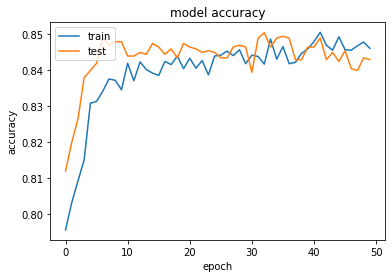

In [34]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

Looks like we were able to improve accuracy from 82.5% with our Random Forest model to greater than 84% using Neural Nets. 